In [1]:
import numpy as np
from numpy import sin,cos,tan,pi
import time
from matplotlib import cm
import matplotlib.pyplot as plt
from tqdm import tqdm

In order to calculate the error of our method for the resulution of the PDE, we are going before to caracterize the numerical laplacian

In [2]:
def DDx_per(M,dx):
    I,J = M.shape
    ddxM = np.zeros([I,J])
    for j in range(J):
        if j == J-1:
            ddxM[:,j] = (M[:,2]-2*M[:,j]+M[:,j-2])/dx**2
        elif j == 0:
            ddxM[:,j] = (M[:,j+2]-2*M[:,j]+M[:,-3])/dx**2
        elif j == 1:
            ddxM[:,j] = (M[:,j+2]-2*M[:,j]+M[:,-2])/dx**2
        elif j == J-2:
            ddxM[:,j] = (M[:,1]-2*M[:,j]+M[:,j-2])/dx**2
        else:
            ddxM[:,j] = (M[:,j+2]-2*M[:,j]+M[:,j-2])/dx**2
    return ddxM

def DDy_per(M,dy):
    I,J = M.shape
    ddyM = np.zeros([I,J])
    for i in range(I):
        if i == I-1:
            ddyM[i,:] = (M[2,:]-2*M[i,:]+M[i-2,:])/dy**2
        elif i == 0:
            ddyM[i,:] = (M[i+2,:]-2*M[i,:]+M[-3,:])/dy**2
        elif i == 1:
            ddyM[i,:] = (M[i+2,:]-2*M[i,:]+M[-2,:])/dy**2
        elif i == I-2:
            ddyM[i,:] = (M[1,:]-2*M[i,:]+M[i-2,:])/dy**2
        else:
            ddyM[i,:] = (M[i+2,:]-2*M[i,:]+M[i-2,:])/dy**2
    return ddyM

def DDx_Neu(M,dx,Bound_left,Bound_right):
    I,J = M.shape
    ddxM = np.zeros([I,J])
    for j in range(1,J-1):
        if j == J-1:
            ddxM[:,j] = (Bound_right-2*M[:,j]+M[:,j-1])/dx**2
        elif j == 0:
            ddxM[:,j] = (M[:,j+1]-2*M[:,j]+Bound_left)/dx**2
        else:
            ddxM[:,j] = (M[:,j+1]-2*M[:,j]+M[:,j-1])/dx**2
    return ddxM
def DDy_Neu(M,dy,Bound_up,Bound_down):
    I,J = M.shape
    ddyM = np.zeros([I,J])
    for i in range(1,I-1):
        if i == I-1:
            ddyM[i,:] = (Bound_down-2*M[i,:]+M[i-1,:])/dy**2
        elif i == 0:
            ddyM[i,:] = (M[i+1,:]-2*M[i,:]+Bound_up)/dy**2
        else:
            ddyM[i,:] = (M[i+1,:]-2*M[i,:]+M[i-1,:])/dy**2
    return ddyM

In [3]:
Er = []
N = np.concatenate((np.arange(10,500,20),np.arange(500,2000,100),np.arange(2000,7000,500)))
for N_sp in tqdm(N):
    L = 2*pi
    dx = L/(N_sp-1)
    xvec = np.linspace(0,L,N_sp)
    yvec = np.linspace(0,L,N_sp)
    [X,Y] = np.meshgrid(xvec,yvec)
    u = sin(X)*sin(Y)
    Lapu = -2*u
    Lap_num = DDx_Neu(u,dx,0,0)+DDy_Neu(u,dx,0,0)
    Error = np.mean(np.abs(Lapu[1:N_sp-1,1:N_sp-1]-Lap_num[1:N_sp-1,1:N_sp-1]))
    Er.append(Error)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


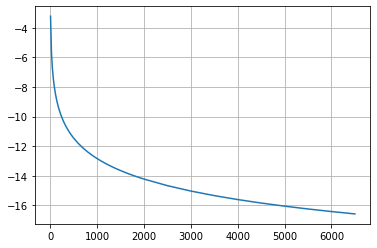

In [4]:
plt.plot(N,np.log(np.abs(Er)))
plt.grid()

In [10]:
class poisson_equation():
    def __init__(self,rho,N,L,kmax = 1000,mu = 1e-3,precision = 1e-6):
        self.kmax = kmax
        self.N = N
        self.L = L
        self.u = []
        self.dx = L/(N-1)
        self.mu = mu
        self.rho = rho
        self.precision = precision
        [self.X,self.Y] = np.meshgrid(np.linspace(0,L,N),np.linspace(0,L,N))
        self.first = True
        self.error = []
    def jacobi_solver(self,iter = 50,controlerr = False):
        if self.first:
            phi_new = np.zeros([N,N])
            phi = phi_new
            self.first = False
        else:
            phi_new = self.u
            phi = self.u
        for k in tqdm(range(iter)):
            for i in range(1,N-1):
                for j in range(1,N-1):
                    phi_new[i,j] =+0.25*(phi[i+1,j]+phi[i-1,j]+phi[i,j+1]+phi[i,j-1])-0.25*self.dx**2*self.rho[i,j]/self.mu
            if controlerr:
                self.error.append(np.abs(np.mean(DDx_Neu(phi_new,self.dx,0,0)+DDy_Neu(phi_new,self.dx,0,0)-p/self.mu)))
            phi = phi_new
        self.u = phi
    def gauss_sheidel_solver(self,iter = 50,controlerr = False):
        if self.first:
            phi_new = np.zeros([N,N])
            phi = phi_new
            self.first = False
        else:
            phi_new = self.u
            phi = self.u
        k = 0
        for k in tqdm(range(iter)):
            for i in range(1,N-1):
                for j in range(1,N-1):
                    phi_new[i,j] =+0.25*(phi[i+1,j]+phi_new[i-1,j]+phi[i,j+1]+phi_new[i,j-1])-0.25*self.dx**2*self.rho[i,j]/self.mu
            if controlerr:
                self.error.append(np.abs(np.mean(DDx_Neu(phi_new,self.dx,0,0)+DDy_Neu(phi_new,self.dx,0,0)-p/self.mu)))
            phi = phi_new
        self.u = phi
    def get_simulation(self):
        return self.u,self.X,self.Y,self.dx,self.error

In [11]:
N = 20
p = -np.ones([N,N])*100
test = poisson_equation(p,N,10,mu = 1)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1656.48it/s]


Text(0.5, 0, 'Number of iteration')

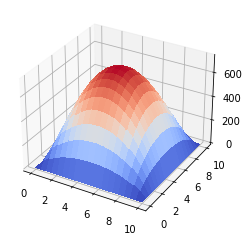

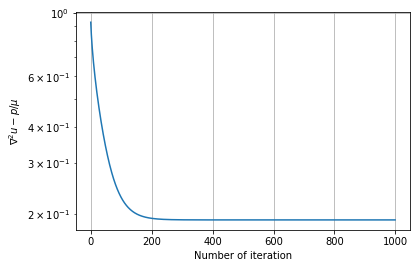

In [12]:
test.jacobi_solver(iter = 1000,controlerr  =True)
u,x,y,dx,error = test.get_simulation()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x,y,u,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.figure()
plt.plot(error/np.mean(np.abs(p)))
plt.yscale('log')
plt.grid()
plt.ylabel(r'$\nabla^2 u-p/\mu$')
plt.xlabel('Number of iteration')

In [13]:
N = 250
p = -np.ones([N,N])*100
test2 = poisson_equation(p,N,10,mu = 1)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:38<00:00, 12.21it/s]


Text(0.5, 0, 'Number of iteration')

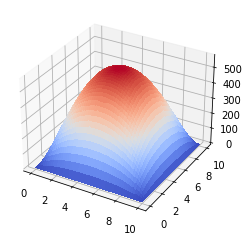

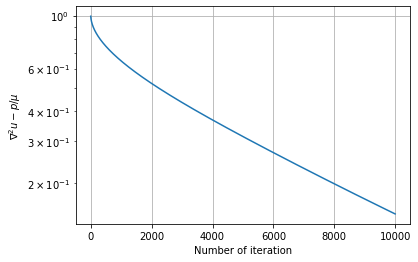

In [14]:
test2.jacobi_solver(iter = 10000,controlerr  =True)
u,x,y,dx,error = test2.get_simulation()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x,y,u,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.figure()
plt.plot(error/np.mean(np.abs(p)))
plt.yscale('log')
plt.grid()
plt.ylabel(r'$\nabla^2 u-p/\mu$')
plt.xlabel('Number of iteration')

In [15]:
N = 20
p = -np.ones([N,N])*100
test_gauss = poisson_equation(p,N,10,mu = 1)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1671.60it/s]


Text(0.5, 0, 'Number of iteration')

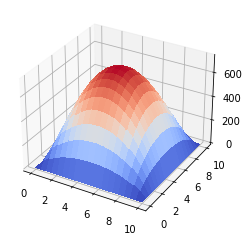

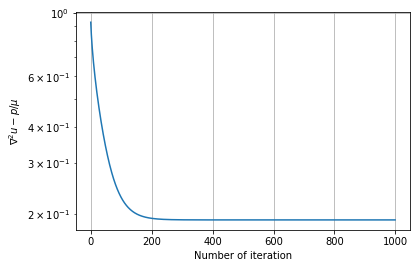

In [16]:
test_gauss.gauss_sheidel_solver(iter = 1000,controlerr  = True)
u,x,y,dx,error = test_gauss.get_simulation()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x,y,u,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.figure()
plt.plot(error/np.mean(np.abs(p)))
plt.yscale('log')
plt.grid()
plt.ylabel(r'$\nabla^2 u-p/\mu$')
plt.xlabel('Number of iteration')

In [17]:
N = 100
p = -np.ones([N,N])*100
test_gauss2 = poisson_equation(p,N,10,mu = 1)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:46<00:00, 75.24it/s]


Text(0.5, 0, 'Number of iteration')

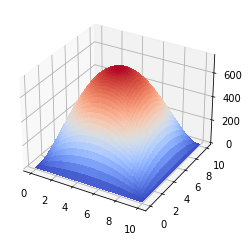

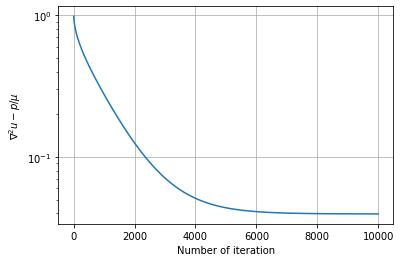

In [22]:
test_gauss2.gauss_sheidel_solver(iter = 1000,controlerr  = True)
u,x,y,dx,error = test_gauss2.get_simulation()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x,y,u,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.figure()
plt.plot(error/np.mean(np.abs(p)))
plt.yscale('log')
plt.grid()
plt.ylabel(r'$\nabla^2 u-p/\mu$')
plt.xlabel('Number of iteration')